Slide 1
<!--- ![](../reports/presentations/20231205/1.png) -->

# Pipeline

Slides 2-4
<!--- ![](../reports/presentations/20231205/2.png)
![](../reports/presentations/20231205/3.png)
![](../reports/presentations/20231205/4.png)--->

## Setup

### Imports

In [11]:
# External imports
import os
import sys
import spacy


# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Relative imports
from src.utils import ld_spcy_mdl
from src.preprocess import Preprocessor
from src.modelling import get_constraints_from_data
from src.evaluation import cnstrnts_gs, sbert_smlarty, sbert_smlarty_cmpntns, evlt_prec_rec

### Files

In [12]:
# Define variables to use as keys
aktg = "AktG"
cdm_01 = "CDM 01: A/R Mangroves"
cdm_02 = "CDM 02: A/R Non-wetlands"
cdm_03 = "CDM 03: Cable Cars"
cdm_04 = "CDM 04: Energy Efficiency"
cdm_05 = "CDM 05: Electriciy Generation"
coffee = "Coffee"
patg = "PatG"

# Define file paths
file_paths_input = {
    aktg: os.path.join('..', 'data', 'aktg', 'input_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'input_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'input_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'input_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'input_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'input_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'input_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'input_patg.txt'),  
}

file_paths_output = {
    aktg: os.path.join('..', 'data', 'aktg', 'output_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'output_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'output_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'output_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'output_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'output_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'output_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'output_patg.txt'),  
}

### Parameter

In [15]:
# spaCy model
model = 'en_core_web_lg'

# Load the spaCy model
nlp = ld_spcy_mdl(model=model)

# Define custom stop words
add_stpwrds = []
non_stpwrds = list(
    """
a above all amount and as at

be before below between beyond both by

can

each either else even except

for

i if 

last least less

may more most must 

name next no none not nothing

of on only otherwise over or out

per

same several should

than then to

under up

what when with
""".split()
)

# This is needed because spaCy struggles with linebreak characters, but the information is needed for the enumeration (see also https://github.com/explosion/spaCy/issues/7735)
linebreak = " NEWLINE "

# Define character sequences to replace
replace = {
    ",": " , ", # Remove this line if any numbers with thousands (e.g. 1,000.00)
    "\n\n": "\n", 
    "\n \n": "\n",
    "\n \n\n": "\n",
    "\n\n \n": "\n",
    "\n": linebreak,
    "   ": " ",
    "  ": " "
} 

# Define character sequences to remove
remove=["\t"]

# Patterns for different enumeration items types for regex matching (to split into chunks)
enum_patterns = {
    'number_in_parentheses': r"\(\d+\)",
    'number_with_dot': r"\d+\.",
    'alphabetical_in_parentheses': r"\([a-z]\)",
    'roman_numeral_in_parentheses': r"\([ivxlcdm]+\)",
}

# Patterns for different enumeration items types for spaCy matching (to label enumeration tokens)
# Every pattern has to follow a linebreak; additionally, the order of the pattern has to be followed (e.g., "v" as alphabetical_in_parentheses can only be a match, if the previous one was also alphabetical_in_parentheses 
enum_patterns_spacy = {
    'number_in_parentheses': [{"TEXT": "("}, {"IS_DIGIT": True}, {"TEXT": ")"}],
    'number_with_dot': [{"IS_DIGIT": True}, {"TEXT": "."}, {"IS_DIGIT": False}],
    'alphabetical_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["a", "b", "c", "d", "e", "f", "g", "h"]}}, {"TEXT": ")"}],
    'roman_numeral_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii"]}}, {"TEXT": ")"}],
}

no_digit_or_period = [{"TEXT": {"NOT_IN": ["."]}, "IS_DIGIT": False, "OP": "*"}]

# Define inequality matching parameters
inequality_params = {
    "general": {
        "below": "<",
        "less than": "<",
        "low than": "<",
        "small than": "<",
        "as high as": "<=",
        "at most": "<=",
        "up to": "<=",
        "remain at": "<=",
        "eligibility limit of": "<=",
        "above": ">",
        "beyond": ">",
        "exceed": ">",
        "great than": ">",
        "high than": ">",
        "more than": ">",
        "surpass": ">",
        "at least": ">="
    },
    "exceptions": {
    },
    "exception_patterns": {
        # coffee
        "reach_beyond": [{"LOWER": "reach"}] + no_digit_or_period + [{"LIKE_NUM": True}] + no_digit_or_period + [{"LOWER": "beyond"}],
        "low_allow": [{"LOWER": "low"}] + no_digit_or_period + [{"LOWER": "allow"}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "between": [{"LOWER": "between"}, {"LIKE_NUM": True}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "brackets": [{"TEXT": "["}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": "]"}],
        "parentheses": [{"TEXT": "("}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": ")"}]
    },
    "negation_operators": {
        "<": ">=",
        "<=": ">",
        ">": "<=",
        ">=": "<"
    },
    "negation_tokens": {"not", "no"},
    "window_size": (12, 0) # Very long
}

# Define equality matching parameters
equality_params = {
    "general": {
        "must": "==",
        "shall": "==",
        "should": "=="
    },
    "exceptions": {
        # aktg
        "be to set out": "==",
        "applicable under": "==",
        # cdm_01
        "apply to": "==",
        # cdm_02
        "applicable to": "==",
        # cdm_03
        "eligible under": "==",
        # cdm_04
        "allowable project include": "==",
        # cdm_05
        "category comprise": "==",
        "include category": "==",
        "be limit to": "==",
        # patg
        "be to be": "=="
    },
    "exception_patterns": {
        # aktg
        "may_only": [{"LOWER": "may"}] + no_digit_or_period + [{"LOWER": "only"}],
        # cdm_01
        "fall_in": [{"LOWER": "fall"}] + no_digit_or_period + [{"LOWER": "category"}],
        # cdm_04
        "none_may": [{"LOWER": "none"}] + no_digit_or_period + [{"LOWER": "may"}],
    },
    "negation_operators": {
        "==": "!="
    },
    "negation_tokens": {"not", "no"},
    "window_size": (3, 2)
}

# Define meta matching parameters
# Due to the complex nature of the meta constraint searching process, some meta parametesr are also implicitly set within the MetaConstraintSearcher class
meta_params = {
    "enum_exceptions": {
        # cdm 02
        "be include": "OR",
        # cdm 05
        "at least one of": "OR"
    },
    "if_patterns": {
        "if_then": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}, "OP": "?"}, {"LOWER": "then"}],
        "if_comma": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        "if_case_of_comma": [{"LOWER": "case"}, {"LOWER": "of"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        
    },
    "for_patterns": {
        "for_colon": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [".",";",",", "for"]}, "OP": "*"},{"TEXT": {"IN": [":"]}}],
        "for_comma": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [":",".",";","for", ",", "---"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["if"]}}]
    },
    "connectors": {
        "and": "AND",
        "and or": "OR",
        "or": "OR",
        "except when": "OR",
        # ";": "AND",
    },
    # Format is (pattern_name, matching_pattern): connector
    "connector_exception_pattern": {
        "semicolon": (";","AND")
    },
    "negation_tokens": {"not", "no"},   # Used for if_patterns
    "window_size": (0, 5),              # Used for if_patterns
    "context_limits": [".", ";"]
}

The model en_core_web_lg is already installed!


## Preprocessing

In [4]:
# Create preprocessing object
pp = Preprocessor(nlp, file_paths_input, verbose=False)

# Add and remove custom stop words globally to the spacy.util.get_lang_class('en')
stpwrds = pp.chng_stpwrds(add=add_stpwrds,remove=non_stpwrds, remove_numbers=True)

# Uncomment this line to restore the default set of stpwrds
# stpwrds = chng_stpwrds(restore_default=True, verbose=True)

# Process all files
data = pp.optimized_preprocessing(replace, remove, linebreak, enum_patterns, enum_patterns_spacy)

## Modelling

### Constraint Search

In [9]:
spacy.explain("nsubjpass")

'nominal subject (passive)'

In [5]:
constraints = get_constraints_from_data(nlp, data, equality_params, inequality_params, meta_params, verbose=True)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

AKTG 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 



establishment of by - law
 ( 1 ) by - law must be establish by way of be record by a notary

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (11, 11)  MUST       False        (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (5, 21)

('STEP_2', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


authorised representative may act only if a power of attorney certify by a notary

  id  type    match    pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   2  EQ      (2, 4)   MAY_ONLY   True         (None, False)  NA              0  (1, 'FOLLOW')  (3, 'FOLLOW')  (0, 13)

('STEP_4', 'CONSTRAINT')

++++ CHUNK ++++ 



( 2 ) deed be to set out follow particular :
 1 . founder ;
 2 . for par - value share : nominal amount ; for no - par - value share : number , issue price and , if several class of stock exist , class of stock each founder acquire ;
 3 . amount of share capital be pay .

  id  type    match           pattern              exception    negation       symbol      level  predecessor     successor       context
----  ------  --------------  -------------------  -----------  -------------  --------  -------  --------------  --------------  ---------
   3  EQ      (4, 7)          BE_TO_SET_OUT        True         (None, False)  ==              0  (2, 'FOLLOW')   (4, 'FOLLOW')   (0, 10)
   4  META    ((11, 12), 14)  ENUM                 False        NA             NA              1  (3, 'AND')      (5, 'AND')      (11, 14)
   5  META    (13, 13)        BOOL                 False        NA             ==              0  (4, 'FOLLOW')   (6, 'FOLLOW')   (13, 13)
   6  META    ((15, 16), 53)  ENU

( 3 ) by - law must determine :
 1 . company business name and seat ;
 2 . purpose of enterprise ; specifically , industrial and trade enterprise be to provide detail regard nature of product and good be intend to manufacture and trade ;
 3 . amount of share capital ;
 4 . division of share capital either par - value share or no - par - value share ; for par - value share , nominal amount and number of share per nominal amount be to be cite ; for no - par - value share , number ; furthermore , if several class of stock exist , class of stock and number of share of stock up each class ;
 5 . share of stock be issue as bearer share or register name of holder ;
 6 . number of member management board be to , or rule accord to number be establish .

  id  type    match              pattern              exception    negation       symbol      level  predecessor     successor       context
----  ------  -----------------  -------------------  -----------  -------------  --------  -------  ---

( 4 ) furthermore , by - law must include determination as to formal requirement apply to company notice by publication

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  48  EQ      (8, 8)    MUST       False        (None, False)  ==              0  (47, 'FOLLOW')  (49, 'FOLLOW')  (0, 15)
  49  EQ      (15, 16)  APPLY_TO   True         (None, False)  ==              0  (48, 'FOLLOW')  (50, 'FOLLOW')  (8, 20)

('STEP_8', 'CONSTRAINT')

++++ CHUNK ++++ 



( 5 ) by - law may deviate provision of present Act only be expressly permit

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  50  EQ      (6, 12)  MAY_ONLY   True         (None, False)  NA              0  (49, 'FOLLOW')  (51, 'FOLLOW')  (0, 15)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 

supplement by - law by additional determination be permissible present Act provide conclusively for matter

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

CDM 01: A/R MANGROVES 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

<

++++ CHUNK ++++ 

-- Source fo

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


methodology apply to afforestation and reforestation ( a / r ) project activity implement degraded mangrove habitat

  id  type    match    pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (1, 2)   APPLY_TO   True         (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (0, 16)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 

REMOVED CONNECTOR: 11


methodology be applicable under follow condition :
 ( a ) land subject to project activity be degrade mangrove habitat ;
 ( b ) More than 90 per cent of project area be plant with mangrove specie . if more than 10 per cent of project area be plant with non - mangrove specie then project activity not lead to alteration of hydrology of project area and hydrology of connect up - gradient and - gradient wetland area ;
 ( c ) soil disturbance attributable to A / r clean development mechanism ( CDM ) project activity not cover more than 10 per cent of area .

  id  type    match            pattern           exception    negation       symbol      level  predecessor     successor       context
----  ------  ---------------  ----------------  -----------  -------------  --------  -------  --------------  --------------  ---------
   2  EQ      (2, 3)           APPLICABLE_UNDER  True         (None, False)  ==              0  (1, 'FOLLOW')   (3, 'FOLLOW')   (0, 6)
   3  META    ((7, 9), 19)     

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


a project activity apply methodology shall comply with applicability condition of tool contain methodology and apply by project activity

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  12  EQ      (5, 5)   SHALL      False        (None, False)  ==              0  (11, 'FOLLOW')  (13, 'FOLLOW')  (0, 18)

('STEP_5', 'CONSTRAINT')

++++ CHUNK ++++ 

date of entry force of revision be date of publication of EB 75 meeting report on 4 October 2013

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

CDM 02: A/R NON-WETLANDS 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


methodology be applicable to small - scale afforestation and reforestation ( a / r ) project activity under clean development mechanism ( CDM )

  id  type    match    pattern        exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  -------------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (2, 3)   APPLICABLE_TO  True         (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (0, 23)

('STEP_10', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


not apply to large - scale a / r CDM project activity

  id  type    match    pattern    exception    negation    symbol      level  predecessor    successor      context
----  ------  -------  ---------  -----------  ----------  --------  -------  -------------  -------------  ---------
   2  EQ      (1, 2)   APPLY_TO   True         (0, True)   !=              0  (1, 'FOLLOW')  (3, 'FOLLOW')  (0, 11)

('STEP_1', 'CONSTRAINT')

++++ CHUNK ++++ 



methodology be applicable under follow condition :
 ( a ) land subject to project activity not fall wetland category ;
 ( b ) soil disturbance attributable to project activity not cover more than 10 per cent of area each of follow type of land , when land be include project boundary :
 ( i ) land contain organic soil ;
 ( ii ) Land , baseline , be subject to land - use and management practice and receive input list appendix 2 and 3 to methodology .

  id  type    match           pattern           exception    negation       symbol      level  predecessor     successor       context
----  ------  --------------  ----------------  -----------  -------------  --------  -------  --------------  --------------  ---------
   3  EQ      (2, 3)          APPLICABLE_UNDER  True         (None, False)  ==              0  (2, 'FOLLOW')   (4, 'FOLLOW')   (0, 6)
   4  META    ((7, 9), 19)    ENUM              False        NA             NA              1  (3, 'AND')      (5, 'AND')      (7, 19)
   5 

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


a project activity apply methodology shall comply with applicability condition of tool contain methodology and apply by project activity

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  12  EQ      (5, 5)   SHALL      False        (None, False)  ==              0  (11, 'FOLLOW')  (13, 'FOLLOW')  (0, 18)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 

date of entry force be date of publication of EB 85 meeting report on 24 July 2015

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

CDM 03: CABLE CARS 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


category comprise cable car substitute traditional road - base transport trip

  id  type    match    pattern            exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  -----------------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (0, 1)   CATEGORY_COMPRISE  True         (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (0, 10)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 

calculation of baseline and project emission be base on total emission trip origin ( o ) to trip destination ( D ) use distinctive mode of transport

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


methodology be applicable to project activity reduce emission construction and operation of new cable car for passenger transport passenger perform partial or total trip on cable car

  id  type    match    pattern        exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  -------------  -----------  -------------  --------  -------  -------------  -------------  ---------
   2  EQ      (2, 3)   APPLICABLE_TO  True         (None, False)  ==              0  (1, 'FOLLOW')  (3, 'FOLLOW')  (0, 26)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


extension of exist cable car be not eligible under methodology

  id  type    match    pattern         exception    negation    symbol      level  predecessor    successor      context
----  ------  -------  --------------  -----------  ----------  --------  -------  -------------  -------------  ---------
   3  EQ      (7, 8)   ELIGIBLE_UNDER  True         (6, True)   !=              0  (2, 'FOLLOW')  (4, 'FOLLOW')  (0, 9)

('STEP_7', 'CONSTRAINT')

++++ CHUNK ++++ 

cable car be establish as a means of mass transit

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


cable car must be build area be accessible by road , i.e. origin and final destination of cable car

  id  type    match    pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   4  EQ      (2, 2)   MUST       False        (None, False)  ==              0  (3, 'FOLLOW')  (5, 'FOLLOW')  (0, 18)

('STEP_2', 'CONSTRAINT')

++++ CHUNK ++++ 

fuel use baseline and or project case be electricity , gaseous or liquid fossil fuel

++++ CHUNK ++++ 

REMOVED CONNECTOR: 5


/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


if bio fuel blend be use as liquid fuel , specific fuel consumption value and emission factor use for determine baseline and project emission shall be adjust accordingly

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   5  META    (0, 9)    IF_COMMA   False        (None, False)  NA              0  (4, 'AND')     (6, 'AND')     (0, 24)
   6  META    (1, 8)    BOOL       False        NA             ==              0  (5, 'FOLLOW')  (7, 'FOLLOW')  (1, 8)
   7  META    (10, 13)  BOOL       False        NA             ==              0  (6, 'FOLLOW')  (8, 'FOLLOW')  (10, 13)
   8  EQ      (24, 24)  SHALL      False        (None, False)  ==              0  (7, 'FOLLOW')  (9, 'FOLLOW')  (9, 27)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 

analysis of possible baseline scenario alternative lead to bas

measure be limit to result emission reduction of less than or equal to 60 kt co2e annually

  id  type    match    pattern                exception    negation       symbol      level  predecessor    successor       context
----  ------  -------  ---------------------  -----------  -------------  --------  -------  -------------  --------------  ---------
   9  INEQ    (8, 13)  LESS_THAN_OR_EQUAL_TO  False        (None, False)  <=              0  (8, 'FOLLOW')  (10, 'FOLLOW')  (3, 16)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 

date of entry force be date of publication of EB 85 meeting report on 24 July 2015

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

CDM 04: ENERGY EFFICIENCY 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

<

+++

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


methodology be applicable to on - site building energy supply and building energy efficiency project associated emission reduction can be determine with a building computerized simulation tool

  id  type    match    pattern        exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  -------------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (2, 3)   APPLICABLE_TO  True         (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (0, 26)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 



methodology apply to commercial building for both retrofit and new construction ( i.e. Greenfield ) project

  id  type    match    pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   2  EQ      (1, 2)   APPLY_TO   True         (None, False)  ==              0  (1, 'FOLLOW')  (3, 'FOLLOW')  (0, 15)

('STEP_1', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


allowable project include energy efficient building design feature ; energy efficient appliance , equipment and/or technology ; energy management control ; on - site renewable energy project ; on - site cogeneration ; and/or fossil fuel switching – or combination

  id  type    match    pattern                    exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  -------------------------  -----------  -------------  --------  -------  -------------  -------------  ---------
   3  EQ      (0, 2)   ALLOWABLE_PROJECT_INCLUDE  True         (None, False)  ==              0  (2, 'FOLLOW')  (4, 'FOLLOW')  (0, 8)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


all technology ( e.g. equipment or appliance ) use project activity must be new and not transfer project activity

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   4  EQ      (11, 11)  MUST       False        (None, False)  ==              0  (3, 'FOLLOW')  (5, 'FOLLOW')  (0, 18)

('STEP_5', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


methodology be not applicable to project activity affect - site district heating and/or cool plant and distribution network even if supply energy to subject building(s )

  id  type    match    pattern        exception    negation    symbol      level  predecessor    successor      context
----  ------  -------  -------------  -----------  ----------  --------  -------  -------------  -------------  ---------
   5  EQ      (3, 4)   APPLICABLE_TO  True         (2, True)   !=              0  (4, 'FOLLOW')  (6, 'FOLLOW')  (0, 25)

('STEP_5', 'CONSTRAINT')

++++ CHUNK ++++ 



if energy efficient equipment contain refrigerant , then refrigerant use project case shall no ozone deplete Potential ( ODP )

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   6  META    (0, 7)    IF_THEN    False        (None, False)  NA              0  (5, 'AND')     (7, 'AND')     (0, 12)
   7  META    (1, 6)    BOOL       False        NA             ==              0  (6, 'FOLLOW')  (8, 'FOLLOW')  (1, 6)
   8  EQ      (12, 12)  SHALL      False        (13, True)     !=              0  (7, 'FOLLOW')  (9, 'FOLLOW')  (7, 19)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 



if project activity include fuel switching , requirement AMS - III.B " switch fossil fuel " for establish a baseline for fuel switching shall be follow

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
   9  META    (0, 6)    IF_COMMA   False        (None, False)  NA              0  (8, 'AND')      (10, 'AND')     (0, 23)
  10  META    (1, 5)    BOOL       False        NA             ==              0  (9, 'FOLLOW')   (11, 'FOLLOW')  (1, 5)
  11  EQ      (23, 23)  SHALL      False        (None, False)  ==              0  (10, 'FOLLOW')  (12, 'FOLLOW')  (6, 25)

('STEP_10', 'CONSTRAINT')

++++ CHUNK ++++ 



none of project equipment , system or action use for claim emission reduction may be include CDM project order to avoid possible double counting of emission reduction

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  12  EQ      (0, 13)  NONE_MAY   True         (None, False)  NA              0  (11, 'FOLLOW')  (13, 'FOLLOW')  (0, 26)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



Project Design Document ( PDD ) shall document potential for double counting of emission reduction , for example to equipment manufacturer or claim credit for emission reduction for project activity , be avoid

  id  type    match     pattern       exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  13  EQ      (6, 6)    SHALL         False        (None, False)  ==              0  (12, 'FOLLOW')  (14, 'FOLLOW')  (0, 9)
  14  META    (21, 21)  CONNECTOR_OR  False        NA             NA              0  (13, 'OR')      (15, 'OR')      (9, 32)

('STEP_8', 'CONSTRAINT')

++++ CHUNK ++++ 



aggregate electricity saving by a single project shall not exceed 60 GWh per year

  id  type    match    pattern    exception    negation    symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  ----------  --------  -------  --------------  --------------  ---------
  15  INEQ    (9, 10)  EXCEED     False        (8, True)   <=              0  (14, 'FOLLOW')  (16, 'FOLLOW')  (7, 13)

('STEP_10', 'CONSTRAINT')

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

CDM 05: ELECTRICIY GENERATION 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

<

++++ CHUNK ++++ 

-- Source for methodology guideline : - > UNFCCC CDM , AMS - I.A. : electricity generation by user --- version 19.0 , https://cdm.unf

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


category comprise renewable electricity generation unit , as solar photovoltaic , hydro , wind and renewable biomass supply electricity to individual household / user or group of household / user

  id  type    match    pattern            exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  -----------------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (0, 1)   CATEGORY_COMPRISE  True         (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (0, 29)

('STEP_10', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


methodology be applicable to project activity involve new installation ( greenfield ) or replace exist onsite fossil - fuel - fire generation

  id  type    match    pattern        exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  -------------  -----------  -------------  --------  -------  -------------  -------------  ---------
   2  EQ      (2, 3)   APPLICABLE_TO  True         (None, False)  ==              0  (1, 'FOLLOW')  (3, 'FOLLOW')  (0, 21)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 



applicability of methodology be limit to individual household and user not a grid connection except when :
 ( a ) a group of household or user be supply with electricity a standalone mini - grid power by renewable energy generation unit(s ) capacity of generating unit not exceed 15 mw ( i.e. sum of instal capacity of all renewable energy unit connect to mini - grid be less than 15 MW ) , e.g. a community - base stand - - - grid renewable electricity system ; or
 ( b ) for renewable energy - base lighting application , emission reduction per system be less than 5 tonne of co2e a year and shall be demonstrate fossil fuel be use absence of project activity by :
 ( i ) a representative sample survey of target household ; or
 ( ii ) official statistic host country government agency ;
 ( c ) a group of household or user be connect to a grid prior to start date of project activity ( or start date of validation with justification ) , electricity grid be available for household and user for les

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


methodology be not applicable to project activity include unit be connect to grid at time crediting period

  id  type    match    pattern        exception    negation    symbol      level  predecessor     successor       context
----  ------  -------  -------------  -----------  ----------  --------  -------  --------------  --------------  ---------
  24  EQ      (3, 4)   APPLICABLE_TO  True         (2, True)   !=              0  (23, 'FOLLOW')  (25, 'FOLLOW')  (0, 16)

('STEP_7', 'CONSTRAINT')

++++ CHUNK ++++ 



hydro power plant with reservoir satisfy at least one of follow condition be eligible to apply methodology :
 ( a ) project activity be implement exist reservoir with no change volume of reservoir ;
 ( b ) project activity be implement exist reservoir , volume of reservoir be increase and power density of project activity be great than 4 W / m2 ;
 ( c ) project activity result new reservoir and power density of power plant be great than 4 W / m2 .

  id  type    match           pattern               exception    negation       symbol      level  predecessor     successor       context
----  ------  --------------  --------------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  25  INEQ    (6, 8)          AT_LEAST              False        (None, False)  >=              0  (24, 'FOLLOW')  (26, 'FOLLOW')  (0, 17)
  26  META    ((18, 20), 33)  ENUM_AT_LEAST_ONE_OF  True         NA             NA              1  (25, 'OR')      (27, 'OR')   

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


combined heat and power ( cogeneration ) system be not eligible under category

  id  type    match     pattern         exception    negation    symbol      level  predecessor     successor       context
----  ------  --------  --------------  -----------  ----------  --------  -------  --------------  --------------  ---------
  32  EQ      (10, 11)  ELIGIBLE_UNDER  True         (9, True)   !=              0  (31, 'FOLLOW')  (33, 'FOLLOW')  (0, 12)

('STEP_1', 'CONSTRAINT')

++++ CHUNK ++++ 



if electricity generation unit add both renewable and non - renewable component ( e.g. a wind / diesel unit ) , eligibility limit of 15 MW for a small - scale CDM project activity apply only to renewable component

  id  type    match     pattern               exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  --------------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  33  META    (0, 20)   IF_COMMA              False        (None, False)  NA              0  (32, 'AND')     (34, 'AND')     (0, 21)
  34  META    (1, 19)   BOOL                  False        NA             ==              0  (33, 'FOLLOW')  (35, 'FOLLOW')  (1, 19)
  35  INEQ    (21, 24)  ELIGIBILITY_LIMIT_OF  False        (None, False)  <=              0  (34, 'FOLLOW')  (36, 'FOLLOW')  (20, 38)
  36  META    (21, 21)  BOOL                  False        NA             ==              0  (35, 'FOLLOW')  (37, 'FO

if unit add co - fires fossil fuel , capacity of entire unit shall not exceed limit of 15 MW

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  37  META    (0, 8)    IF_COMMA   False        (None, False)  NA              0  (36, 'AND')     (38, 'AND')     (0, 13)
  38  META    (1, 7)    BOOL       False        NA             ==              0  (37, 'FOLLOW')  (39, 'FOLLOW')  (1, 7)
  39  INEQ    (15, 18)  EXCEED     False        (14, True)     <=              0  (38, 'FOLLOW')  (40, 'FOLLOW')  (13, 19)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


project activity involve retrofit or replacement of exist renewable electricity generation unit be include category

  id  type    match     pattern           exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ----------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  40  EQ      (13, 14)  INCLUDE_CATEGORY  True         (None, False)  ==              0  (39, 'FOLLOW')  (41, 'FOLLOW')  (0, 14)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 



to qualify as a small - scale project , total output of modify or retrofit unit shall not exceed limit of 15 MW

  id  type    match     pattern    exception    negation    symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  ----------  --------  -------  --------------  --------------  ---------
  41  INEQ    (18, 21)  EXCEED     False        (17, True)  <=              0  (40, 'FOLLOW')  (42, 'FOLLOW')  (16, 22)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


case of project activity involve addition of renewable electricity generation unit to exist renewable electricity generation facility , total capacity of unit add by project should be low than 15 mw and should be physically distinct exist unit

  id  type    match     pattern           exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ----------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  42  META    (0, 17)   IF_CASE_OF_COMMA  False        (None, False)  NA              0  (41, 'AND')     (43, 'AND')     (0, 25)
  43  META    (1, 16)   BOOL              False        NA             ==              0  (42, 'FOLLOW')  (44, 'FOLLOW')  (1, 16)
  44  META    (18, 30)  BOOL              False        NA             ==              0  (43, 'FOLLOW')  (45, 'FOLLOW')  (18, 30)
  45  INEQ    (27, 29)  LOW_THAN          False        (None, False)  <               0  (44, 'FOLLOW')  (4

hot air reach temperature of between 450 and 485 degree Fahrenheit

  id  type    match    pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  -------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  INEQ    (5, 8)   BETWEEN    True         (None, False)  NA              0  (0, 'START')   (2, 'FOLLOW')  (0, 10)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 

believe method of roasting create of good coffee taste for a reason

++++ CHUNK ++++ 

first , a unique method of remove chaff coffee bean shed as heat

++++ CHUNK ++++ 

be important coffee bean be absorbent if chaff remain chamber roast , as drum roaster , soak up of unwanted flavor

++++ CHUNK ++++ 

reason be efficiency heat transference

++++ CHUNK ++++ 

machine can reach high temperature half of time of drum roaster , be absolutely essential to ensure a smooth cup of coffee with least amount of acidity possible

+++

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


if damage or malfunction be to be experience , then be crucial upper management be notify delay

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   2  META    (0, 9)    IF_THEN    False        (None, False)  NA              0  (1, 'AND')     (3, 'AND')     (0, 16)
   3  EQ      (4, 6)    BE_TO_BE   True         (None, False)  ==              0  (2, 'FOLLOW')  (4, 'FOLLOW')  (0, 9)
   4  META    (10, 16)  BOOL       False        NA             ==              0  (3, 'FOLLOW')  (5, 'FOLLOW')  (10, 16)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 

insulate Roasting Chamber be option : owner add a layer of heat - proof insulation exterior of roasting chamber

++++ CHUNK ++++ 

insulation allow Quest to retain more heat , increase capacity and speed of heating

++++ CHUNK ++++ 

, downside be if user 

first distinguish between a tray height of less than 180 mm and high or equal to 180 mm :
 -- > coffee tray height low than 180 mm :
 inherently can not allow a temperature of roast oven 1 to below 120 ° or above 400 °

  id  type    match     pattern           exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ----------------  -----------  -------------  --------  -------  --------------  --------------  ---------
   5  INEQ    (7, 9)    LESS_THAN         False        (None, False)  <               0  (4, 'FOLLOW')   (6, 'FOLLOW')   (0, 12)
   6  META    (11, 11)  CONNECTOR_AND     False        NA             NA              0  (5, 'AND')      (7, 'AND')      (0, 18)
   7  INEQ    (12, 16)  HIGH_OR_EQUAL_TO  False        (None, False)  >=              0  (6, 'FOLLOW')   (8, 'FOLLOW')   (9, 18)
   8  INEQ    (24, 26)  LOW_THAN          False        (None, False)  <               0  (7, 'FOLLOW')   (9, 'FOLLOW')   (19, 28)
   

roast oven 2 should maintain temperature as [ 220 ° , 500 ° ]

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  12  INEQ    (7, 13)  BRACKETS   True         (None, False)  NA              0  (11, 'FOLLOW')  (13, 'FOLLOW')  (3, 13)

('STEP_5', 'CONSTRAINT')

++++ CHUNK ++++ 



final product present a good quality if high temperature of roast oven 3 remain at 550 °

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  13  INEQ    (13, 15)  REMAIN_AT  False        (None, False)  <=              0  (12, 'FOLLOW')  (14, 'FOLLOW')  (0, 16)

('STEP_8', 'CONSTRAINT')

++++ CHUNK ++++ 



-- > coffee tray height of at least 180 mm :
 roast oven 1 should follow temperature rule [ 140 ° , 420 ° ]

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  14  INEQ    (6, 8)    AT_LEAST   False        (None, False)  >=              0  (13, 'FOLLOW')  (15, 'FOLLOW')  (0, 10)
  15  INEQ    (18, 24)  BRACKETS   True         (None, False)  NA              0  (14, 'FOLLOW')  (16, 'FOLLOW')  (14, 24)

('STEP_7', 'CONSTRAINT')

++++ CHUNK ++++ 



, be not allow for roast oven 2 to above 520 ° or below 240 °

  id  type    match     pattern       exception    negation    symbol      level  predecessor     successor       context
----  ------  --------  ------------  -----------  ----------  --------  -------  --------------  --------------  ---------
  16  INEQ    (9, 10)   ABOVE         False        (2, True)   <=              0  (15, 'FOLLOW')  (17, 'FOLLOW')  (0, 13)
  17  META    (12, 12)  CONNECTOR_OR  False        NA          NA              0  (16, 'OR')      (18, 'OR')      (0, 15)
  18  INEQ    (13, 14)  BELOW         False        (2, True)   >=              0  (17, 'FOLLOW')  (19, 'FOLLOW')  (10, 15)

('STEP_1', 'CONSTRAINT')

++++ CHUNK ++++ 



finally , product not pass quality standard if roast oven 3 fail to maintain temperature below 571 °

  id  type    match     pattern    exception    negation    symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  ----------  --------  -------  --------------  --------------  ---------
  19  INEQ    (15, 16)  BELOW      False        (3, True)   >=              0  (18, 'FOLLOW')  (20, 'FOLLOW')  (0, 17)

('STEP_10', 'CONSTRAINT')

++++ CHUNK ++++ 

- > Medium Roast : roast oven 1 , 2 , 3 and 4

++++ CHUNK ++++ 

medium roast be medium brown to brown with no oil on surface , dark roast group may appear slightly shiny

++++ CHUNK ++++ 

be balanced , exhibit significant flavor and aroma

++++ CHUNK ++++ 

medium Roast coffee be brown and a little thick body than a Light Roast

++++ CHUNK ++++ 

unlike Light , Medium start to on a bit of taste roasting process , lose of bright floral flavor be typical of a Light Roast

++++ CHUNK ++++ 

for a successful medium roast of coffee bean follow technical requirement should be follow :
 -- > coffee tray height of at most 170 mm :
 temperature of roast 1 should follow [ 170 ° , 450 ° ]

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  20  EQ      (11, 11)  SHOULD     False        (None, False)  ==              0  (19, 'FOLLOW')  (21, 'FOLLOW')  (0, 14)
  21  INEQ    (21, 23)  AT_MOST    False        (None, False)  <=              0  (20, 'FOLLOW')  (22, 'FOLLOW')  (15, 25)
  22  INEQ    (32, 38)  BRACKETS   True         (None, False)  NA              0  (21, 'FOLLOW')  (23, 'FOLLOW')  (30, 38)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



temperature of roast 2 should follow [ 270 ° , 550 ° ]

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  23  INEQ    (6, 12)  BRACKETS   True         (None, False)  NA              0  (22, 'FOLLOW')  (24, 'FOLLOW')  (4, 12)

('STEP_1', 'CONSTRAINT')

++++ CHUNK ++++ 



temperature of roast 3 should follow [ 370 ° , 650 ° ]

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  24  INEQ    (6, 12)  BRACKETS   True         (None, False)  NA              0  (23, 'FOLLOW')  (25, 'FOLLOW')  (4, 12)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 



temperature of roast 4 should not exceed 550 °

  id  type    match    pattern    exception    negation    symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  ----------  --------  -------  --------------  --------------  ---------
  25  INEQ    (6, 7)   EXCEED     False        (5, True)   <=              0  (24, 'FOLLOW')  (26, 'FOLLOW')  (4, 8)

('STEP_10', 'CONSTRAINT')

++++ CHUNK ++++ 



-- > coffee tray height of at least 170 mm :
 temperature of roast 1 should avoid ( 0 ° , 180 ° ) and ( 460 ° , 1000 ° )

  id  type    match     pattern        exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  -------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  26  INEQ    (6, 8)    AT_LEAST       False        (None, False)  >=              0  (25, 'FOLLOW')  (27, 'FOLLOW')  (0, 10)
  27  INEQ    (17, 23)  PARENTHESES    True         (None, False)  NA              0  (26, 'FOLLOW')  (28, 'FOLLOW')  (15, 25)
  28  META    (24, 24)  CONNECTOR_AND  False        NA             NA              0  (27, 'AND')     (29, 'AND')     (15, 31)
  29  INEQ    (25, 31)  PARENTHESES    True         (None, False)  NA              0  (28, 'FOLLOW')  (30, 'FOLLOW')  (23, 31)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



temperature of roast 2 should avoid ( 0 ° , 290 ° ) and ( 570 ° , 1000 ° )

  id  type    match     pattern        exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  -------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  30  INEQ    (6, 12)   PARENTHESES    True         (None, False)  NA              0  (29, 'FOLLOW')  (31, 'FOLLOW')  (4, 14)
  31  META    (13, 13)  CONNECTOR_AND  False        NA             NA              0  (30, 'AND')     (32, 'AND')     (4, 20)
  32  INEQ    (14, 20)  PARENTHESES    True         (None, False)  NA              0  (31, 'FOLLOW')  (33, 'FOLLOW')  (12, 20)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 



temperature of roast 3 should avoid ( 0 ° , 390 ° ) and ( 670 ° , 1000 ° )

  id  type    match     pattern        exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  -------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  33  INEQ    (6, 12)   PARENTHESES    True         (None, False)  NA              0  (32, 'FOLLOW')  (34, 'FOLLOW')  (4, 14)
  34  META    (13, 13)  CONNECTOR_AND  False        NA             NA              0  (33, 'AND')     (35, 'AND')     (4, 20)
  35  INEQ    (14, 20)  PARENTHESES    True         (None, False)  NA              0  (34, 'FOLLOW')  (36, 'FOLLOW')  (12, 20)

('STEP_2', 'CONSTRAINT')

++++ CHUNK ++++ 



temperature of roast 4 should reach at most 560 °

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  36  INEQ    (6, 8)   AT_MOST    False        (None, False)  <=              0  (35, 'FOLLOW')  (37, 'FOLLOW')  (4, 9)

('STEP_7', 'CONSTRAINT')

++++ CHUNK ++++ 

- > Dark Roast : dark roast be dark brown to black , coffee bean roast exude oil and oil sheen glow on surface

++++ CHUNK ++++ 

roasting process flavor overwhelm bean ' flavor , and coffee bean may taste spicy , bitter or smoky

++++ CHUNK ++++ 



to be consider dark , bean roast to a temperature of high than 440 ° or essentially to end of second crack

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  37  INEQ    (11, 13)  HIGH_THAN  False        (None, False)  >               0  (36, 'FOLLOW')  (38, 'FOLLOW')  (0, 21)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 

if bean roast hot than 780 ° , coffee start to taste more and more of charcoal and not pass final quality check

++++ CHUNK ++++ 

roasting degree be only one require use of roast oven 5

++++ CHUNK ++++ 



if coffee pile on tray reach 175 mm and beyond , then roast oven 5 should not temperature exceed 580 °

  id  type    match     pattern       exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  38  META    (0, 11)   IF_THEN       False        (None, False)  NA              0  (37, 'AND')     (39, 'AND')     (0, 15)
  39  INEQ    (5, 9)    REACH_BEYOND  True         (None, False)  NA              0  (38, 'FOLLOW')  (40, 'FOLLOW')  (0, 11)
  40  INEQ    (18, 19)  EXCEED        False        (16, True)     <=              0  (39, 'FOLLOW')  (41, 'FOLLOW')  (15, 20)

('STEP_5', 'CONSTRAINT')

++++ CHUNK ++++ 



similarly , for coffee pile small than 175 mm , roast oven 5 should not beyond 560 °

  id  type    match     pattern     exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ----------  -----------  -------------  --------  -------  --------------  --------------  ---------
  41  META    (2, 9)    FOR_COMMA   False        NA             NA              0  (40, 'AND')     (42, 'AND')     (2, 13)
  42  INEQ    (5, 7)    SMALL_THAN  False        (None, False)  <               0  (41, 'FOLLOW')  (43, 'FOLLOW')  (2, 9)
  43  INEQ    (15, 16)  BEYOND      False        (14, True)     <=              0  (42, 'FOLLOW')  (44, 'FOLLOW')  (13, 17)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



big - batch roaster cut corner by roast large quantity fast at extremely high temperature for a short amount of time be important for to respect a new pattern of roasting begin at oven chamber 1 , if coffee pile be at least 175 mm high then roast oven 1 should not exceed 580 ° and low temperature allow be 220 ° , similarly for roast oven 2 temperature reach at most 680 ° and no low than 320 °

  id  type    match     pattern        exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  -------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  44  META    (37, 62)  IF_COMMA       False        (None, False)  NA              0  (43, 'AND')     (45, 'AND')     (37, 70)
  45  INEQ    (41, 43)  AT_LEAST       False        (None, False)  >=              0  (44, 'FOLLOW')  (46, 'FOLLOW')  (37, 50)
  46  INEQ    (52, 53)  EXCEED         False        (51, True)     <=              0  (45, 'FOL

continue process , if roast oven 3 above 780 ° or if roast oven 4 exceed 680 ° , final product be reject

  id  type    match     pattern       exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  53  META    (3, 18)   IF_COMMA      False        (None, False)  NA              0  (52, 'AND')     (54, 'AND')     (3, 22)
  54  INEQ    (7, 8)    ABOVE         False        (None, False)  >               0  (53, 'FOLLOW')  (55, 'FOLLOW')  (3, 11)
  55  META    (10, 10)  CONNECTOR_OR  False        NA             NA              0  (54, 'OR')      (56, 'OR')      (3, 22)
  56  META    (11, 18)  IF_COMMA      False        (None, False)  NA              0  (55, 'AND')     (57, 'AND')     (11, 22)
  57  INEQ    (15, 16)  EXCEED        False        (None, False)  >               0  (56, 'FOLLOW')  (58, 'FOLLOW')  (11, 18)
  58  META    (

same outcome happen if roast oven 3 fail to maintain at least 421 ° or if roast oven 4 low than 320 °

  id  type    match     pattern       exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  59  INEQ    (10, 12)  AT_LEAST      False        (None, False)  >=              0  (58, 'FOLLOW')  (60, 'FOLLOW')  (0, 19)
  60  META    (14, 14)  CONNECTOR_OR  False        NA             NA              0  (59, 'OR')      (61, 'OR')      (0, 22)
  61  INEQ    (19, 21)  LOW_THAN      False        (None, False)  <               0  (60, 'FOLLOW')  (62, 'FOLLOW')  (12, 22)

('STEP_6', 'CONSTRAINT')

++++ CHUNK ++++ 



, for pile of height , roast oven 1 should remain between 200 ° and 560 ° include both temperature

  id  type    match     pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  62  META    (1, 5)    FOR_COMMA  False        NA             NA              0  (61, 'AND')     (63, 'AND')     (1, 9)
  63  META    (2, 4)    BOOL       False        NA             ==              0  (62, 'FOLLOW')  (64, 'FOLLOW')  (2, 4)
  64  INEQ    (11, 15)  BETWEEN    True         (None, False)  NA              0  (63, 'FOLLOW')  (65, 'FOLLOW')  (9, 19)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 



pile of size can accept temperature of at least 300 ° and up to 660 ° for roast chamber 2 , if surpass 760 ° or if temperature drop below 400 ° at roast oven 3 , then final product undoubtedly be reject

  id  type    match     pattern        exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  -------------  -----------  -------------  --------  -------  --------------  --------------  ---------
  65  INEQ    (7, 9)    AT_LEAST       False        (None, False)  >=              0  (64, 'FOLLOW')  (66, 'FOLLOW')  (0, 12)
  66  META    (11, 11)  CONNECTOR_AND  False        NA             NA              0  (65, 'AND')     (67, 'AND')     (0, 21)
  67  INEQ    (12, 14)  UP_TO          False        (None, False)  <=              0  (66, 'FOLLOW')  (68, 'FOLLOW')  (9, 21)
  68  META    (21, 37)  IF_THEN        False        (None, False)  NA              0  (67, 'AND')     (69, 'AND')     (21, 42)
  69  INEQ    (22, 23)  SURPASS      

finally , respect order to achieve first crack coffee bean , oven chamber 4 should as high as 680 ° not drop below 320 °

  id  type    match     pattern     exception    negation       symbol      level  predecessor     successor       context
----  ------  --------  ----------  -----------  -------------  --------  -------  --------------  --------------  ---------
  74  INEQ    (15, 18)  AS_HIGH_AS  False        (None, False)  <=              0  (73, 'FOLLOW')  (75, 'FOLLOW')  (14, 22)
  75  INEQ    (22, 23)  BELOW       False        (20, True)     >=              0  (74, 'FOLLOW')  (76, 'FOLLOW')  (18, 24)

('STEP_9', 'CONSTRAINT')

++++ CHUNK ++++ 

Quest owner – to increase maximum batch capacity or alter roast environment thermal dynamic – paint roasting drum ’ exterior with high - heat matte black spray paint

++++ CHUNK ++++ 

cause drum to efficiently absorb and conduct more infrared heat to roast chamber independent of airflow speed ( convection )

++++ CHUNK ++++ 

increase

( 1 ) application for grant of a patent for invention be to be file with German Patent and Trade Mark Office

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (11, 13)  BE_TO_BE   True         (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (0, 21)

('STEP_3', 'CONSTRAINT')

++++ CHUNK ++++ 



( 3 ) application must contain :
 1 . name of applicant ;
 2 . a request for grant of a patent clearly and concisely describe invention ;
 3 . one or more patent claim indicate what be to be protect as patentable ;
 4 . a description of invention ;
 5 . drawing refer to patent claim or description .

  id  type    match           pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  --------------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
   2  EQ      (4, 4)          MUST       False        (None, False)  ==              0  (1, 'FOLLOW')   (3, 'FOLLOW')   (0, 6)
   3  META    ((7, 8), 12)    ENUM       False        NA             NA              1  (2, 'AND')      (4, 'AND')      (7, 12)
   4  META    (9, 11)         BOOL       False        NA             ==              0  (3, 'FOLLOW')   (5, 'FOLLOW')   (9, 11)
   5  META    ((13, 14), 27)  ENUM       False        NA 

( 4 ) application must disclose invention a manner be sufficiently clear and complete for to be carry out by a person skilled art

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  13  EQ      (4, 4)   MUST       False        (None, False)  ==              0  (12, 'FOLLOW')  (14, 'FOLLOW')  (0, 23)

('STEP_10', 'CONSTRAINT')

++++ CHUNK ++++ 



( 5 ) application must relate to one invention only or to a group of invention link as to form a single general inventive concept

  id  type    match    pattern    exception    negation       symbol      level  predecessor     successor       context
----  ------  -------  ---------  -----------  -------------  --------  -------  --------------  --------------  ---------
  14  EQ      (4, 4)   MUST       False        (None, False)  ==              0  (13, 'FOLLOW')  (15, 'FOLLOW')  (0, 24)

('STEP_10', 'CONSTRAINT')

++++ CHUNK ++++ 

( 6 ) Federal Ministry of Justice and Consumer Protection be authorise to issue , by statutory instrument , provision concern form and requirement of application

++++ CHUNK ++++ 

may , by statutory instrument , delegate authorisation to German Patent and Trade Mark Office

++++ CHUNK ++++ 

( 7 ) at request of German Patent and Trade Mark Office applicant be to specify state of art to good of or knowledge , fully and truthfully , and to include descrip

## Evaluation

In [6]:
constraints_dummy_cdm = {
    # Exact match
    "c1": "({check project type}, {check connection type}, {directly follows}, {project type == new installation OR project type == replacing existing fossil-fuel-fired generation})",
    # Close match
    "c2": "({check power plant type}, {check hydro power plant}, {directly follows}, {power plant type == hydro power})",
    # No match
    "c3": "({check combustion}, {check emissions}, {directly follows}, {fuel == coal})"
}
constraints_dummy_cdm = {
    'c1': '({check transport mode}, {check project type}, {directly follows}, {transport_mode == cable_car})',
    'c2': '({check project type}, {verify road accessibility}, {directly follows}, {project_type == new_construction})',
    'c3': '({verify road accessibility}, {assess fuel type}, {directly follows}, {accessibility == accessible_by_road})',
    'c4': '({assess fuel type}, {evaluate baseline scenario}, {directly follows}, {fuel_type in [electricity, gaseous_fossil, liquid_fossil, bio_fuel_blend]})',
    'c5': '({evaluate baseline scenario}, {check emission reduction measures}, {directly follows}, {baseline_scenario == represents_continuation_of_current_transport_system})',
    'c6': '({check emission reduction measures}, {apply methodology}, {directly follows}, {emission_reduction <= 60})'
}
constraints_dummy_cdm = constraints[cdm_01]["formatted"]

### Calculating similarity scores

In [7]:
# Transform content to dictionary
constraints_gs_cdm = cnstrnts_gs(file_paths_output[cdm_01])

In [8]:
similarity_scores = sbert_smlarty(constraints_dummy_cdm, constraints_gs_cdm, model='all-mpnet-base-v2')

In [9]:
matches_step_1, matches_step_2, matches_constraints = sbert_smlarty_cmpntns(similarity_scores, constraints_dummy_cdm, constraints_gs_cdm, threshold=0, model='paraphrase-MiniLM-L6-v2', matching_mode='unique')

### Calculating final score

Precision: 0.12997941772143046
Maximum precision: 1.0
Recall: 0.07798765063285827
Maximum recall: 0.6


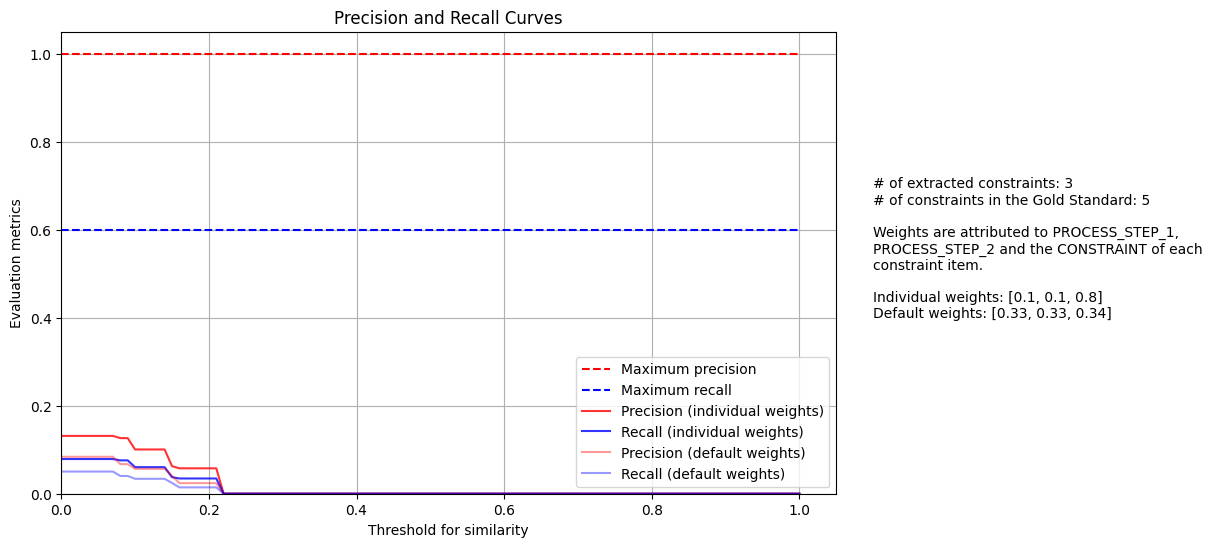

In [10]:
evlt_prec_rec(constraints_dummy_cdm, constraints_gs_cdm, matches_step_1, matches_step_2, matches_constraints, individual_weights=True, weights=[0.1, 0.1, 0.8], hard_cut=False, threshold=0.8, plot_curves=True, save_plot=False)


![](../reports/presentations/20231205/5.png)
![](../reports/presentations/20231205/6.png)


![](../reports/presentations/20231205/7.png)